In this notebook, we will build the first part of the model's pipeline : *The initial SDF prediction*

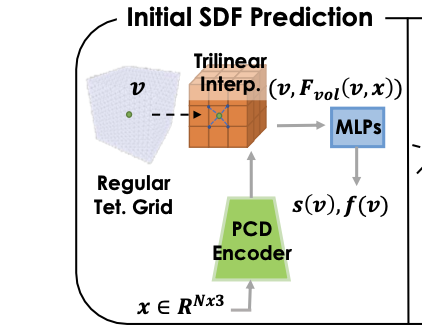

# Installing Dependencies: Kaolin and PyTorch3D

In [1]:
# When trying to compute the sdf, I tried using this library https://pypi.org/project/mesh-to-sdf/
# However, there are some issues when running it on Google Collab :
# Specifically, it needs a python > 3.8 and reinstall the primary libraries in this python (torch e.g)
# Even after using the right environment, there are still some errors.. 
# You're happy to try to solve them, the SDF cells are at the bottom of the notebook

# TLDR : No need to run this cell if you don't intend to use this sdf library
try_SDF = False
if try_SDF :

    #check python version
    import sys
    print(sys.version)
    !python3 --version
    !python --version


    #install python 3.9 and dev utils
    #you may not need all the dev libraries, but I haven't tested which aren't necessary.
    !sudo apt-get update -y
    !sudo apt-get install python3.9 python3.9-dev python3.9-distutils libpython3.9-dev

    #change alternatives
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

    # install pip
    !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
    !python3 get-pip.py --force-reinstall

    #install colab's dependencies
    !python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

    # link to the old google package
    !ln -s /usr/local/lib/python3.7/dist-packages/google \
          /usr/local/lib/python3.9/dist-packages/google



    print(sys.version)
    !python3 --version
    !python --version


    !pip install sklearn
    !pip install -U scikit-learn scipy matplotlib
    !pip install mesh-to-sdf
    !pip install trimesh
    !pip install tqdm
    !pip install torch



In [2]:
# reinstall cython, install usd-core (for 3D rendering), and clone into kaolin repo
!pip install usd-core
!git clone --recursive https://github.com/NVIDIAGameWorks/kaolin
%cd kaolin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.7 MB 1.4 MB/s 
Cloning into 'kaolin'...
remote: Enumerating objects: 4237, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 4237 (delta 31), reused 116 (delta 21), pack-reused 4054
Receiving objects: 100% (4237/4237), 87.85 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (2235/2235), done.
Submodule 'third_party/cub' (https://github.com/NVIDIA/cub) registered for path 'third_party/cub'
Cloning into '/content/kaolin/third_party/cub'...
remote: Enumerating objects: 32125, done.        
remote: Counting objects: 100% (399/399), done.        
remote: Compressing objects: 100% (215/215), done.        
remote: Total 32125 (delta 228), reused 325 (delta 181), pack-reused 31726        
Receiving objects: 100% (32125/32125), 17.26 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (27128/2

In [3]:
# installing kaolin and check version
%env IGNORE_TORCH_VER=1
%env KAOLIN_INSTALL_EXPERIMENTAL=1
!python setup.py develop
!python -c "import kaolin; print(kaolin.__version__)"

env: IGNORE_TORCH_VER=1
env: KAOLIN_INSTALL_EXPERIMENTAL=1
setup.py:36: UserWarning: Kaolin is compatible with PyTorch >=1.6.0, <=1.13.0, but found version 1.13.0+cu116. Continuing with the installed version as IGNORE_TORCH_VER is set.
  warnings.warn(
setup.py:63: UserWarning: Kaolin requires cython == 0.29.20, but found version 0.29.32 instead.
  warnings.warn('Kaolin requires cython == 0.29.20, '
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
WARNING - Torch did not find available GPUs on this system.
Kaolin will install only with CPU support and will have very limited features.
If your wish to cross-compile for GPU `export FORCE_CUDA=1` before running setup.py
By default, Apex will cross-compile for Pascal (compute capabilities 6.0, 6.1, 6.2),
Volta (compute capability 7.0), Turing (compute capability 7.5),
and, if the CUDA version is >= 11.0, Ampere (compute capability 8.0).
If you wish to cross-compile for a single specific architecture,
export TORCH_CUDA_ARCH_LIST="

# Import packages

In [4]:
import numpy as np
import torch
import kaolin

from kaolin.io.shapenet import (
    ShapeNetV2
)

In [5]:
!pip install torch
import numpy as np
import torch
import kaolin

from kaolin.io.shapenet import (
    ShapeNetV2
)

import os
import sys
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   841k      0 --:--:-- --:--:-- --:--:--     0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-ibsy4eik
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-ibsy4eik
  Running command git checkout -q 995b60e3b99faa1ee1bcdbe244426d54d98a7242
     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.7.1-cp38-cp38-linux_x86_64

# Import Dataset: Subset of ShapeNetV2

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(f'Device used  : {device}')

Device used  : cpu


In [8]:
# SHAPENET_PATH = "/content/drive/MyDrive/FALL 2022/Computer Vision/Project/willis/Core"
SHAPENET_PATH = "/content/drive/MyDrive/FALL 2022/Computer Vision/Project/Core"
# SYNSETS_IDS = ['02747177', '02773838', '02801938', '02808440', '02818832', '02828884', '02843684', '02871439', '02876657', '02880940', '02924116', '02933112']
SYNSETS_IDS = ['02843684']

shapenet_train = ShapeNetV2(SHAPENET_PATH, categories=SYNSETS_IDS, output_dict=True)
shapenet_test = ShapeNetV2(SHAPENET_PATH, categories=SYNSETS_IDS, output_dict=True, train=False)

In [9]:
"""
shapenet_train contains dict that stores a 3D model
"""

sample_model = shapenet_train[2] # change the index here for different models
sample_verts = sample_model['mesh'][0] # Vertices of shape num_vertices x 3 (3 coordinates)
sample_faces = sample_model['mesh'][1] # Triangular faces of shape num_faces x 3 (3 vertices)

# Load the initial tetrahedral grid

We load the tetrahedral grid. We use here an example from kaolin. The tutorial uses Quartet (https://github.com/crawforddoran/quartet) to generate the grid with given resolution

The resolution here is 128

In [10]:
# Shape is num_vertices_tet_grid x 3, it's a list of the 3 coordinates of each of the grid's vertices
tets_verts = torch.tensor(np.load('examples/samples/128_verts.npz')['data'], dtype=torch.float, device=device)

# Shape is num_face_tet_grid x 4, it's a list of the 4 vertices index making each tetrahedra face of the grid
tets_faces = torch.tensor( (np.array([np.load('examples/samples/128_tets_{}.npz'.format(i))['data'] for i in range(4)]) ), dtype=torch.long, device=device).permute(1,0)
print(tets_verts.shape, tets_faces.shape)

torch.Size([277410, 3]) torch.Size([1524684, 4])


# Sample cloud points from surface mesh

In [11]:
# First we sample points on the surface mesh
# We uniformly choose a surface then we uniformly choose a point on this surface
NUM_SAMPLES = 1000
# pc is Shape 1xNUM_SAMPLESx3 (3 coordinates), it's the point cloud
# face_idx is shape 1xNUM_SAMPLES it's the indexes of the faces sampled
pc, face_idx = kaolin.ops.mesh.sample_points(
    vertices= sample_verts.unsqueeze(0), # shape Batch_size x num_vertices x 3
    faces= sample_faces, # shape num_faces x 3
    num_samples= NUM_SAMPLES) 

# PVCNN to extract feature vector for each cloud point

We can try to use the implementation here 
https://github.com/mit-han-lab/pvcnn

But it's hard lol

In [12]:
# # Code Snippet
# features, coords = inputs
# voxel_features, voxel_coords = self.voxelization(features, coords)
# voxel_features = self.voxel_layers(voxel_features)
# voxel_features = F.trilinear_devoxelize(voxel_features, voxel_coords, self.resolution, self.training)
# fused_features = voxel_features + self.point_features(features)

Other idea is to use a Point Cloud Encoder to retrieve a feature vector from the output's activation.

In [13]:
ENCODER_MLP_CONFIG = {
    'input_dim' : 3, # Coordinates of the grid's vertices
    'hidden_dims' : [256, 800, 1600, 1600],
    'output_dim' : 832, # SDF of the vertex input. The other "output" f_v comes from the prior activation layer of dimension 64
}

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class MLP(torch.nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()

        self.input_dim = config['input_dim']
        self.hidden_dims  = config['hidden_dims']
        self.output_dim = config['output_dim']

        # Hidden layers
        self.hiddens = nn.ModuleList()
        in_dim = self.input_dim
        for k in range(len(self.hidden_dims)):
            self.hiddens.append(nn.Linear(in_dim, self.hidden_dims[k]))
            in_dim = self.hidden_dims[k]

        # Output layer
        self.output_layer = torch.nn.Linear(self.hidden_dims[-1], self.output_dim)


    def forward(self, x):
        for hidden in self.hiddens :
            x = F.relu(hidden(x))
        output = self.output_layer(x) # No activation (linear) cuz we do regression

        return output, x # Return output + last feature layer vector

Test

In [71]:
pointnet = MLP(ENCODER_MLP_CONFIG)
pointnet = pointnet.to(device)

pc = pc.to(device)

print(pointnet)
print('\n\n')
summary(pointnet, input_size= pc.shape)

MLP(
  (hiddens): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=800, bias=True)
    (2): Linear(in_features=800, out_features=1600, bias=True)
    (3): Linear(in_features=1600, out_features=1600, bias=True)
  )
  (output_layer): Linear(in_features=1600, out_features=832, bias=True)
)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 1, 1000, 256]           1,024
            Linear-2         [-1, 1, 1000, 800]         205,600
            Linear-3        [-1, 1, 1000, 1600]       1,281,600
            Linear-4        [-1, 1, 1000, 1600]       2,561,600
            Linear-5         [-1, 1, 1000, 832]       1,332,032
Total params: 5,381,856
Trainable params: 5,381,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (

In [72]:
pointnet.eval()
f_vol, _ = pointnet(pc)

print(f'Input Point Cloud is shape {pc.shape} so output feature vectors \
 should be of shape {pc.shape[0], pc.shape[1], 832} and it actually is {tuple(f_vol.shape)}')

Input Point Cloud is shape torch.Size([1, 1000, 3]) so output feature vectors  should be of shape (1, 1000, 832) and it actually is (1, 1000, 832)


# Interpolate feature values on the grid

We implement an inverse distance interpolation based on a K-NN algorithm :
Given N known points and their features and a batch of M points with unknown features, the interpolator find the K nearest neigbors in the set N for each point of the batch M. Then it interpolates the features of the batch points M using an inverse distance weighting of the features of the K known neighbour points. 

K can be fine-tuned to balance efficiency and speed.

Implementation can be found here
https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python

In [61]:
from __future__ import division
import numpy as np
from scipy.spatial import cKDTree as KDTree
    # http://docs.scipy.org/doc/scipy/reference/spatial.html

__date__ = "2010-11-09 Nov"  # weights, doc

#...............................................................................
class Invdisttree:
    """ inverse-distance-weighted interpolation using KDTree:
invdisttree = Invdisttree( X, z )  -- data points, values
interpol = invdisttree( q, nnear=3, eps=0, p=1, weights=None, stat=0 )
    interpolates z from the 3 points nearest each query point q;
    For example, interpol[ a query point q ]
    finds the 3 data points nearest q, at distances d1 d2 d3
    and returns the IDW average of the values z1 z2 z3
        (z1/d1 + z2/d2 + z3/d3)
        / (1/d1 + 1/d2 + 1/d3)
        = .55 z1 + .27 z2 + .18 z3  for distances 1 2 3

    q may be one point, or a batch of points.
    eps: approximate nearest, dist <= (1 + eps) * true nearest
    p: use 1 / distance**p
    weights: optional multipliers for 1 / distance**p, of the same shape as q
    stat: accumulate wsum, wn for average weights

How many nearest neighbors should one take ?
a) start with 8 11 14 .. 28 in 2d 3d 4d .. 10d; see Wendel's formula
b) make 3 runs with nnear= e.g. 6 8 10, and look at the results --
    |interpol 6 - interpol 8| etc., or |f - interpol*| if you have f(q).
    I find that runtimes don't increase much at all with nnear -- ymmv.

p=1, p=2 ?
    p=2 weights nearer points more, farther points less.
    In 2d, the circles around query points have areas ~ distance**2,
    so p=2 is inverse-area weighting. For example,
        (z1/area1 + z2/area2 + z3/area3)
        / (1/area1 + 1/area2 + 1/area3)
        = .74 z1 + .18 z2 + .08 z3  for distances 1 2 3
    Similarly, in 3d, p=3 is inverse-volume weighting.

Scaling:
    if different X coordinates measure different things, Euclidean distance
    can be way off.  For example, if X0 is in the range 0 to 1
    but X1 0 to 1000, the X1 distances will swamp X0;
    rescale the data, i.e. make X0.std() ~= X1.std() .

A nice property of IDW is that it's scale-free around query points:
if I have values z1 z2 z3 from 3 points at distances d1 d2 d3,
the IDW average
    (z1/d1 + z2/d2 + z3/d3)
    / (1/d1 + 1/d2 + 1/d3)
is the same for distances 1 2 3, or 10 20 30 -- only the ratios matter.
In contrast, the commonly-used Gaussian kernel exp( - (distance/h)**2 )
is exceedingly sensitive to distance and to h.

    """
# anykernel( dj / av dj ) is also scale-free
# error analysis, |f(x) - idw(x)| ? todo: regular grid, nnear ndim+1, 2*ndim

    def __init__( self, X, z, leafsize=10, stat=0 ):
        assert len(X) == len(z), "len(X) %d != len(z) %d" % (len(X), len(z))
        self.tree = KDTree( X, leafsize=leafsize )  # build the tree
        self.z = z
        self.stat = stat
        self.wn = 0
        self.wsum = None;

    def __call__( self, q, nnear=6, eps=0, p=1, weights=None ):
            # nnear nearest neighbours of each query point --
        q = np.asarray(q)
        qdim = q.ndim
        if qdim == 1:
            q = np.array([q])
        if self.wsum is None:
            self.wsum = np.zeros(nnear)

        self.distances, self.ix = self.tree.query( q, k=nnear, eps=eps )
        interpol = np.zeros( (len(self.distances),) + np.shape(self.z[0]) )
        jinterpol = 0
        for dist, ix in zip( self.distances, self.ix ):
            if nnear == 1:
                wz = self.z[ix]
            elif dist[0] < 1e-10:
                wz = self.z[ix[0]]
            else:  # weight z s by 1/dist --
                w = 1 / dist**p
                if weights is not None:
                    w *= weights[ix]  # >= 0
                w /= np.sum(w)
                wz = np.dot( w, self.z[ix] )
                if self.stat:
                    self.wn += 1
                    self.wsum += w
            interpol[jinterpol] = wz
            jinterpol += 1
        return interpol if qdim > 1  else interpol[0]

Let's test the interpolation by splitting the point cloud (of size 1000) into a known set of size N= 600 and an unknown batch of M= 400 points

In [73]:
sample_known = pc.squeeze()[:600] # shape 600 x 3. Set of N= 600 points with known features
sample_unknown = pc.squeeze()[600:] # shape 400x3. Batch of M= 400 points on which we will interpolate the features
f_vol_known = f_vol.squeeze()[:600] # Shape 600 x 832. Set of the feature vectors F_vol of the set N
f_vol_unknown = f_vol.squeeze()[600:] # Shape 400 x 832. Ground truth of F_vol for the batch M unknown points. Used to test the interpolation performance


leafsize = 10 # leaf size of the KDTree. This means the KDTree will store "leafsize" number of neighbour points for each data point
eps = .1  # approximate nearest, dist <= (1 + eps) * true nearest
p = 1  # weights ~ 1 / distance**p
Nnear = 8  # 8 2d, 11 3d => 5 % chance one-sided -- Wendel, mathoverflow.com


invdisttree = Invdisttree( sample_known.squeeze().detach(), f_vol_known.squeeze().detach(), leafsize=leafsize, stat=1 )
interpol = invdisttree( sample_unknown.detach(), nnear=Nnear, eps=eps, p=p ) # return numpy array

err = np.abs( f_vol_unknown.detach().numpy() - interpol )
print("average |ground_truth - interpolated|: %.2g" % np.mean(err))

average |ground_truth - interpolated|: 0.00016


Now we compute the F_vol interpolation on the grid vertices

In [81]:
tets_f_vol = invdisttree( tets_verts.detach(), nnear=Nnear, eps=eps, p=p ) # ~ 5-10sec
tets_f_vol = torch.tensor(tets_f_vol)

# Define MLP model for sdf prediction

We follow the paper recommandation and use a four-layer
MLPs with hidden dimensions 256, 256, 128 and 64, respectively

In [24]:
# Since we skip PVCNN, input dimension is just the coordinates of each grid

SDF_MLP_CONFIG = {
    'input_dim' : 3 + 832, # Coordinates of the grid's vertices + F_vol dimension (concatenation)
    'hidden_dims' : [256, 256, 128, 64],
    'output_dim' : 1, # SDF of the vertex input. The other "output" f_v comes from the prior activation layer of dimension 64
}

In [ ]:
sdf_model = MLP(SDF_MLP_CONFIG).to(device)
print(sdf_model)
print('\n\n')
sdf_input = torch.cat(tensors= (tets_f_vol, tets_verts), dim= 1)
summary(sdf_model, input_size= sdf_input[0].shape)

MLP(
  (hiddens): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)





Little test :

In [74]:
pred_sdfs, f_vs = sdf_model(sdf_input)

print(f'Input grid + interpolated F_vol shape is : {sdf_input.shape}')
print(f'Output shape of the predicted SDFs should be {sdf_input.shape[0], 1} and it actually is {tuple(pred_sdfs.shape)}')
print(f'Output shape of the feature vectors f_vs should be {sdf_input.shape[0], 64} and it actually is {tuple(f_vs.shape)}')

Input grid shape is : torch.Size([277410, 3])
Output shape of the predicted SDFs should be (277410, 1) and it actually is (277410, 1)
Output shape of the feature vectors f_vs should be (277410, 64) and it actually is (277410, 64)


# Define loss

To win a little bit of time, let's define the Chamfer Loss and Normal Consistency Loss since we only need the sampling point code to do it.



*   **Chamfer Loss** : Kaolin provides a chamfer loss implemenation directly on the cloud points
*   **Normal Consistency Loss** : Kaolin doesn't provide a direct implementation. We would have to calculate the normals of each triangular surface mesh, then sample points and their estimate normal at the same time and manually calculate the loss.



In [27]:
def chamfer_loss_kaolin(pred_verts, pred_faces, gt_verts, gt_faces, num_samples= 10000):
    # generating point cloud using verts and faces

    pred_sample, _ = kaolin.ops.mesh.sample_points(
        vertices= pred_verts.unsqueeze(0),
        faces= pred_faces,
        num_samples= num_samples
    )

    gt_sample, _ = kaolin.ops.mesh.sample_points(
        vertices= gt_verts.unsqueeze(0),
        faces= gt_faces,
        num_samples= num_samples
    )

    pred_point_cloud = pred_sample.to(device)
    gt_point_cloud = gt_sample.to(device)

    # calculating chamfer distance
    dist = kaolin.metrics.pointcloud.chamfer_distance(pred_point_cloud, gt_point_cloud) # Need GPU

    return dist

little test

In [28]:
loss = chamfer_loss_kaolin(sample_verts, sample_faces, sample_verts, sample_faces) # Need device on GPU

print(f'Loss should be close to 0 and it actully is {loss.item()}')

RuntimeError: ignored

No we test pytorch3D chamfer loss implementation (https://pytorch3d.readthedocs.io/en/latest/modules/loss.html)
This implementation is better bcs it also computes the regularization loss with the normal points

To win a little bit of time, let's define the Chamfer Loss and Normal Consistency Loss since we only need the sampling point code to do it.



*   **Chamfer Loss** : Pytorch3D provides a chamfer loss implemenation directly on the cloud points
*   **Normal Consistency Loss** : Pytorch3D chamfer loss function also returns the normal consistency loss. We just need to use the pytorch3D sample function that samples point cloud + their normal points.


First, we have to create a Mesh object from Pytorch3D

In [ ]:
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance

def chamfer_loss_pytorch3D(pred_verts, pred_faces, gt_verts, gt_faces, num_samples= 10000):
    # generating point cloud using verts and faces

    pred_meshes = Meshes(verts= [pred_verts], faces= [pred_faces])
    gt_meshes = Meshes(verts= [gt_verts], faces= [gt_faces])

    pred_points_sample, pred_normals_sample = sample_points_from_meshes(pred_meshes, num_samples= num_samples, return_normals= True)
    gt_points_sample, gt_normals_sample = sample_points_from_meshes(gt_meshes, num_samples= num_samples, return_normals= True)

    pred_points_sample, pred_normals_sample = pred_points_sample.to(device), pred_normals_sample.to(device)
    gt_points_sample, gt_normals_sample = gt_points_sample.to(device), gt_normals_sample.to(device)

    # calculating chamfer distance
    dist = chamfer_distance(pred_points_sample, gt_points_sample, x_normals= pred_normals_sample, y_normals= gt_normals_sample)

    return dist

In [ ]:
chamfer_loss, consistency_loss = chamfer_loss_pytorch3D(sample_verts, sample_faces, sample_verts, sample_faces) # Need device on GPU
print(f'Both Losses should be close to 0 and Chamfer Loss actually is {chamfer_loss.item()} and Consistency Normal loss is {consistency_loss}')

TODO ! Find a good sdf library for non watertight models or only process valid watertight models..

Now let's define the Regularization SDF loss.
Kaolin lists some sdf implementation in the docs (https://kaolin.readthedocs.io/en/v0.1/notes/conversions_tutorial.html)
However, none of the functions are actually available ??

For this reason I'm using mesh-to-sdf to compute the sdf (https://pypi.org/project/mesh-to-sdf/).
This library uses the trimesh library so we need to create a trimesh mesh object and then compute the sdf

In [ ]:
!pip install pysdf

from pysdf import SDF
f = SDF(sample_verts, sample_faces); # (num_vertices, 3) and (num_faces, 3)
test = f(tets_verts)

print(sample_model['mesh'][0].shape)
print(sample_model['mesh'][0])

In [ ]:
import trimesh
from mesh_to_sdf import mesh_to_sdf
mesh = trimesh.Trimesh(vertices= sample_verts,
                       faces= sample_faces)


points, sdf = mesh_to_sdf(mesh= mesh, query_points= tets_verts.numpy(), sign_method='normal')